In [6]:
from bomberman.Environment import Environnement
from bomberman.states.State import State
import torch
from DQN_Agent import BuffedDQNAgent, Hyperparams
import time

from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from IPython import display

In [7]:
class ReplayBuffer:
    """A simple replay buffer without batch."""

    def __init__(self, size: int):
        self.buffer = []

        self.max_size = size

    def store(
        self,
        data_point : Dict[str, State or List[int] or float or bool],
    ):
        self.buffer.append(data_point)
        if len(self.buffer) > self.max_size:
            self.buffer.pop(-1)

    def sample_batch(self) -> Dict[str, State or List[int] or float or bool]:
        return self.buffer[np.random.choice(len(self))]

    def __len__(self) -> int:
        return len(self.buffer)

In [8]:
class Trainer():
	def __init__(
		self, 
		Agent : BuffedDQNAgent, 
        hp : Hyperparams
	) -> None:
		self.hp = hp

		self.training_agent = Agent(1, hp)
		self.env_training = Environnement(1)

		self.to_beat_agent = Agent(2, hp)
		self.env_to_beat = Environnement(2)

		self.memory = ReplayBuffer(self.hp.replay_buffer_size)

		self.epsilon = self.hp.max_epsilon

		self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )


	def reset(self):
		# Player 1
		state_training = self.env_training.reset()

		# Player 2
		state_to_beat = self.env_to_beat.get_state()
		return state_training, state_to_beat
		
	def compute_reward(self, old_state, next_state, game_over):
		winner = next_state.as_tuple()[2]
		
		if game_over: # if game is over and player is not the winner, return -1 else 1
			return -1. if not winner or winner != self.training_agent.player_num else 1.
		
		return 0
	
	def _plot(
		self, 
		frame_idx: int, 
		scores: List[float], 
		losses: List[float], 
		epsilons: List[float],
	):
		"""Plot the training progresses."""
		clear_output(True)
		plt.figure(figsize=(20, 5))
		plt.subplot(131)
		plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
		plt.plot(scores)
		plt.subplot(132)
		plt.title('loss')
		plt.plot(losses)
		plt.subplot(133)
		plt.title('epsilons')
		plt.plot(epsilons)
		plt.show()

	def _mlflow_start():
		mlflow.start_run()
		mlflow.log_params(self.hp.__dict__)

	def _mlflow_end():
		# tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
		mlflow.pytorch.log_model(
	        pytorch_model = self.training_agent,
			artifact_path = "mlflow/" + str(time.time()),
			conda_env = mlflow.pytorch.get_default_conda_env(),
			code_paths = [] # TODO have list of code files here
	    )
		mlflow.end_run()

	def train(self, log_each : int = 1):
		state_training, state_to_beat = self.reset()
		current_skip = self.hp.skip_frames
		
		i = 1

		# Use a game duration to force agent to finish the game fast
		# (and avoid starting agent which are random to never end playing)
		game_duration = 0

		epsilons = []
		losses = []
		scores = []
		score = 0
		update_count = 0

		while i <= self.hp.training_games_amount:
			game_over = False

			data_point = {"obs": state_training} # need [obs, action, reward, next_obs, done]

			while current_skip > 0 and not game_over:
				with torch.no_grad(): # Don't compute grad for game playing
					time.sleep(0.01)
					
					# To_beat_agent turn
					tobeat_action = self.to_beat_agent.get_action(state_to_beat)
					state_to_beat = self.env_to_beat.do_action(tobeat_action)

					# Then the training agent turn
					training_action = self.training_agent.get_action(state_training, epsilon=self.epsilon)
					state_training = self.env_training.do_action(training_action)

					# if it is the first step of the observation
					if current_skip == self.hp.skip_frames:
						data_point["action"] = training_action 

					current_skip -= 1

					if (state_training.winner is not None) or game_duration >= self.hp.max_game_duration:
						game_over = True
						break
			
			current_skip = self.hp.skip_frames
			game_duration += 1

			data_point["next_obs"] = state_training
			data_point["reward"] = self.compute_reward(data_point["obs"], data_point["next_obs"], game_over)
			data_point["done"] = game_over

			score += data_point["reward"]

			if game_over:
				game_duration = 0
				scores.append(score)
				score = 0
				print("game has been reseted and winner was : ", data_point["next_obs"].as_tuple()[2]) # only for debug TODO remove this line
				state_training, state_to_beat = self.reset()

			self.memory.store(data_point)

			with torch.cuda.amp.autocast():
				if len(self.memory) > 1: # No batch size for the moment
					sample = self.memory.sample_batch()

					loss = self.training_agent.update_model(sample)
					losses.append(loss)

					update_count += 1

					if update_count % self.hp.target_update_regularity == 0:
						self.training_agent._targe_hard_update()

					self.epsilon = max(
						self.hp.min_epsilon, self.epsilon - (self.hp.max_epsilon - self.hp.min_epsilon) * self.hp.epsilon_decay
					)

					epsilons.append(self.epsilon)

			if update_count % log_each == 0:
				self._plot(i, scores, losses, epsilons)


			if i % self.hp.reset_concurent_agent_each == 0: # reset the to beat agent to the current trained agent
				self.to_beat_agent.brain.load_state_dict(self.training_agent.brain.state_dict())

			if i % log_each == 0:
				print(f"{i} steps done")
			i += 1 # TODO : only update i when a step of training is done with the memory

In [9]:
trainer = Trainer(BuffedDQNAgent, Hyperparams())

CONNNNECTING




CONNNNECTEEED




New client Connected!
Handle Basic
Parse Basic: {0}{"requestedType": 1, "pass": "default", "playerNum": 1}
Set Readi
Ready player: 1
CONNNNECTING




CONNNNECTEEED




New client Connected!
Handle Basic
Parse Basic: {0}{"requestedType": 1, "pass": "default", "playerNum": 2}
Set Readi
Ready player: 2


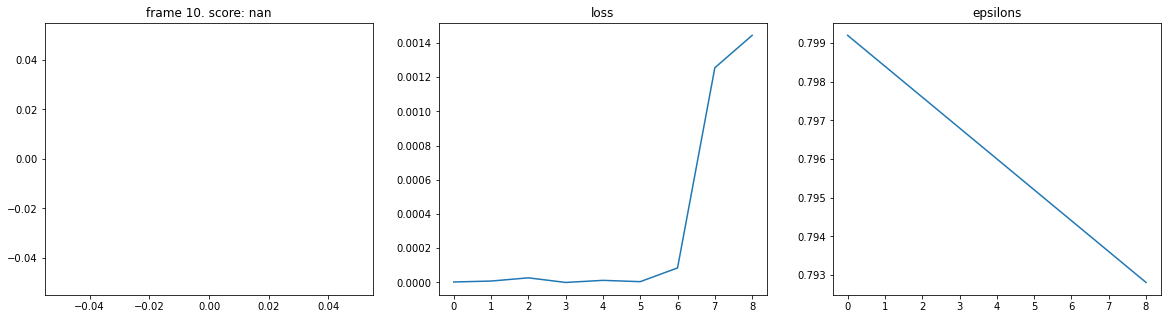

10 steps done


In [10]:
trainer.train()